In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom

In [3]:
ds = pydicom.read_file(str(input('Ingrese un archivo: ')))
ds.file_meta
# 1) Copiar la ruta donde está ubicado nuestro archivo
# 2) Colocar una barra más y copiar el nombre del archivo con la extensión incluida ('.dcm')
# 3) Sólo presionar "enter"

Ingrese un archivo: D:\Users\user\Documents\Tesis Ana\Set de pacientes\PI\1\2-BRAQUITERAPIA\RD.1.3.6.1.4.1.2452.6.2250649552.1266952679.1890813843.1298216529.dcm


(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Dose Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.2452.6.2250649552.1266952679.1890813843.1298216529
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.250.1.59.3.0.3.5.3
(0002, 0013) Implementation Version Name         SH: 'ETIAM_DCMTK_353'
(0002, 0016) Source Application Entity Title     AE: 'OTP_SCU'

In [6]:
#Visualizamos información de interés
ds[:[0x3004, 0x010]]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'DOSE']
(0008, 0012) Instance Creation Date              DA: '20190214'
(0008, 0013) Instance Creation Time              TM: '150141'
(0008, 0016) SOP Class UID                       UI: RT Dose Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.2452.6.2250649552.1266952679.1890813843.1298216529
(0008, 0020) Study Date                          DA: '20190214'
(0008, 0023) Content Date                        DA: '20190214'
(0008, 0030) Study Time                          TM: '134813.203000'
(0008, 0033) Content Time                        TM: '150141'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'RTDOSE'
(0008, 0070) Manufacturer                        LO: 'Nucletron'
(0008, 0090) Referring Physician's Name          PN: 'DRA BRUN'
(0008, 0201) Timezone Offset Fro

In [3]:
braquiarray=ds.pixel_array

print("Nuestra imágen se puede representar con una matriz de dimensión: " + str(braquiarray.shape) + " Y el tipo de datos de cada pixel es: " + str(braquiarray[0,0,0].dtype) + " Y una resolución de " + str(ds.PixelSpacing) + " mm")

Nuestra imágen se puede representar con una matriz de dimensión: (103, 94, 87) Y el tipo de datos de cada pixel es: uint32 Y una resolución de [1.000000, 1.000000] mm


In [7]:
# El objetivo es igualar sólo en tamaño la imágen de dosis a la de tomografía, las dos son de la misma sesión de braquiterapia
# Como las imágenes de tomografía se encuentran sueltas adapatamos un código para poder visualiar nuestra tomografía
# y poder visualizar a qué dimensiones queremos llegar.


In [8]:
import os
import glob

In [10]:
# Cargo la carpeta donde guardé las imágenes de tomografía de interés.
# Aegurarse de hacer los mismos pasos que en el código anterior, pero ésta vez, ingresar sólo la ruta de la carpeta de 
# nuestros archivos.

INPUT_FOLDER = (str(input('Ingrese la ruta de la carpeta de archivos: ')))
patients =  os.listdir(INPUT_FOLDER)
patients.sort()

Ingrese la ruta de la carpeta de archivos: D:\Users\user\Documents\Tesis Ana\tomografía_pt1


In [13]:
lstFilesDCM = []   # creo una lista vacía y voy agreagando los archivos DICOM en la lista
def load_scan2(path):
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():  
                lstFilesDCM.append(os.path.join(dirName, filename))
    return lstFilesDCM

first_patient = load_scan2(INPUT_FOLDER)
print(lstFilesDCM[0:6])  #para visualizar los primeros 7 elementos de la lista

['D:\\Users\\user\\Documents\\Tesis Ana\\tomografía_pt1\\CT.1.3.6.1.4.1.2452.6.1050360180.1080925630.4052450701.2777985367.dcm', 'D:\\Users\\user\\Documents\\Tesis Ana\\tomografía_pt1\\CT.1.3.6.1.4.1.2452.6.1050832576.1256051437.2329617317.1496777816.dcm', 'D:\\Users\\user\\Documents\\Tesis Ana\\tomografía_pt1\\CT.1.3.6.1.4.1.2452.6.1099158148.1152470789.649348487.2294417522.dcm', 'D:\\Users\\user\\Documents\\Tesis Ana\\tomografía_pt1\\CT.1.3.6.1.4.1.2452.6.1103699967.1202030004.3538137739.218986907.dcm', 'D:\\Users\\user\\Documents\\Tesis Ana\\tomografía_pt1\\CT.1.3.6.1.4.1.2452.6.1123829523.1166706541.1582403474.2390353480.dcm', 'D:\\Users\\user\\Documents\\Tesis Ana\\tomografía_pt1\\CT.1.3.6.1.4.1.2452.6.1128137084.1095995010.2735128224.1396351511.dcm']


In [303]:
print (lstFilesDCM[0]) #visualizo el primer elemento de la lista

RefDs = pydicom.read_file(lstFilesDCM[0]) #leo el primer elemento

# Cargo las dimensiones basadas en el numnero de filas, columnas,y cortes(a lo largo del eje z)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Cargo el espácio entre los datos (en mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))


x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

D:\Users\user\Documents\Tesis Ana\tomografía\CT.1.3.6.1.4.1.2452.6.1050360180.1080925630.4052450701.2777985367.dcm


In [304]:
# El arreglo está dimensionado en 'ConstPixelDims'
cortes=[]
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Bucle a través de todos los archivos DICOM
for filenameDCM in lstFilesDCM:
    # Leo el archivo
    ds_ct = pydicom.read_file(filenameDCM)
    cortes.append(ds_ct[0x020, 0x032].value[2])
    # Almaceno los datos de imágen sin procesar
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds_ct.pixel_array

In [354]:
# de todos los cortes, sacamos aquel que tiene el máximo en su coordenada (número de corte en mm)
min(cortes)

"-848.7"

In [305]:
print("Nuestra tomografía se representa con una matriz de dimensión " + str(ArrayDicom.shape) + " Y cada píxel es de tipo " + str(ArrayDicom[0,0,0].dtype) + " Con una resolución de " + str(RefDs.PixelSpacing) + " mm")

Nuestra tomografía se representa con una matriz de dimensión (512, 512, 144) Y cada píxel es de tipo uint16 Con una resolución de [0.8203125, 0.8203125] mm


In [306]:
# Nuestra fórmula para redimensionar sería: DimBraqui=DimRadioMax / PixelSpacingRadio
DimBraqui=braquiarray.shape
DimRadio=ArrayDicom.shape
ResTC=RefDs.PixelSpacing[0]

In [307]:
DimRadio

(512, 512, 144)

In [308]:
DimBraqui

(103, 94, 87)

In [167]:
ceros=np.zeros([int(DimRadio[2]*RefDs.SliceThickness),int(DimRadio[0]*ResTC),int(DimRadio[1]*ResTC)])


In [77]:
ceros.shape

(216, 420, 420)

In [128]:
# Transformamos el tipo de datos para igualarlo con la imágen de braqui
ceros.dtype

dtype('float64')

In [348]:
cerosdosis=ceros.astype(braquiarray.dtype)

In [309]:
#rtdose
rtdose=ds[0x020, 0x032].value
rtdose

[-95.250000, -276.731000, -747.057000]

In [310]:
#tc
tc=RefDs[0x020, 0x032].value
tc

[-249.58984375, -441.58984375, -821.7]

In [346]:
#numero de frames
inicio0=abs(ds[0x020, 0x032].value[2]+braquiarray.shape[0])-abs(int(min(cortes))+(ArrayDicom.shape[2]*RefDs.SliceThickness))
inicio0

12.057000000000016

In [347]:
inicio0=(cerosdosis.shape[0])-inicio0-braquiarray.shape[0]
inicio0

100.94299999999998

In [227]:
#filas
#inicio1= abs(ds[0x020, 0x032].value[1]+braquiarray.shape[1])-abs(RefDs[0x020, 0x032].value[1]+ArrayDicom.shape[0]) 
inicio1=abs(ds[0x020, 0x032].value[1])-abs(RefDs[0x020, 0x032].value[1])
inicio1

-164.85884375

In [228]:
#columnas
inicio2= abs(ds[0x020, 0x032].value[0])-abs(RefDs[0x020, 0x032].value[0]) 
inicio2

-154.33984375

In [349]:
# Realizamos el zeropadding

contador=np.arange(braquiarray.shape[0])

for i in contador:
    cualquiera=braquiarray[i]
    cerosdosis[int(abs(inicio0))+i , int(abs(inicio1)):abs(int(abs(inicio1))+cualquiera.shape[0]) , int(abs(inicio2)):abs(int(abs(inicio2))+cualquiera.shape[1])]=cualquiera 

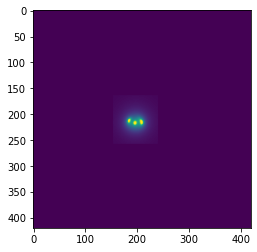

In [367]:
#Visualizamos un corte para corroborar que se hizo el zeropadding como queríamos

plt.imshow(cerosdosis[140,:,:])
plt.show()

In [351]:
# Procesdemos a guardar nuestra nueva imágen

ds.PixelData=cerosdosis.tobytes('C')
ds.Rows,ds.Columns =cerosdosis[0].shape
ds[0x28, 0x08].value=cerosdosis.shape[0]


In [353]:
# Esta parte del codigo es para no sobreescribir las distintas imágenes que vamos modificando
# Acordarse de incluir la extensión '.dcm'

ds.save_as(str(input('Ingrese nombre del archivo')))

Ingrese nombre del archivo'nuevo_braqui_pt1.dcm'


In [45]:
#out_path = "D:/Users/user/Documents/Tesis Ana/Nuevas dosis"
#os.path.join(out_path, image)